# 날씨데이터 기반 서울시 공유자전거 따릉이 수요 예측

### 목표
 * 어떠한 날씨요소가 따릉이 수요와 관련 있는지 분석 및 인사이트 도출

### 데이터
* 1 서울기상관측 및 따릉이 대여 데이터

In [1]:
# 분석
# import sys
import pandas as pd
import scipy.stats as spst

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rc("font", family="Malgun Gothic")
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False}, style='white')

## 1> 개요
|구분||
|-|-|
|파일명|**서울기상관측 및 따릉이 대여 데이터.csv**|
|출처|https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36<br>http://data.seoul.go.kr/dataList/OA-15245/F/1/datasetView.do|
|설명|시간대별 서울시 공공자전거 이용정보 및 서울시 마포구로 날씨 자료|

<br>

|컬럼|설명|
|-|-|
|date|날짜|
|hour|시간|
|temperature|온도|
|precipitation|강우 여부, 비가 오지 않았으면 0, 비가 오면 1|
|windspeed|풍속(평균)|
|humidity|습도|
|visibility|시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)|
|ozone|오존 수치|
|PM10|미세먼지 수치(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)|
|PM2.5|초미세먼지 수치(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)|
|count|시간에 따른 따릉이 대여 수|

## 2> 데이터 전처리

In [3]:
sbike = pd.read_csv('서울기상관측 및 따릉이 대여 데이터.csv')
display(sbike.head(2))
display(sbike.tail(2))

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
0,2021-04-01,1,42.0,21.0,0.002,13.1,0,1.4,49,2000,46
1,2021-04-01,2,41.0,21.0,0.003,12.4,0,2.1,53,2000,40


,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
5825,2021-11-29,23,43.0,35.0,0.001,8.2,0,2.1,71,1262,125
5826,2021-11-30,0,39.0,31.0,0.004,7.9,0,2.3,71,1483,95


In [4]:
sbike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5827 entries, 0 to 5826
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           5827 non-null   object 
 1   hour           5827 non-null   int64  
 2   PM10           5725 non-null   float64
 3   PM2.5          5732 non-null   float64
 4   ozone          5699 non-null   float64
 5   temperature    5827 non-null   float64
 6   precipitation  5827 non-null   int64  
 7   windspeed      5827 non-null   float64
 8   humidity       5827 non-null   int64  
 9   visibility     5827 non-null   int64  
 10  count          5827 non-null   int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 500.9+ KB


### 2-1> 결측치 처리 (PM10, PM2.5, ozone)

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
sbike_drop = sbike.drop(columns=['date', 'count'], axis=1)

In [7]:
# 결측치가 많은데 시계열데이터이므로 K-Nearest Neighbors 알고리즘을 바탕으로 결측치 채우기
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV

params = {'n_neighbors': [3, 5, 7, 9, 11]} # 완전탐색할 파라미터

grid_search = GridSearchCV(estimator=KNNImputer(), # 이웃 간 유사성을 비교
                           param_grid=params,
                           scoring='neg_mean_squared_error', # MSE
                           cv=5) # 교차 검증 횟수

grid_search.fit(sbike_drop)
print("KNNImputer 최적 파라미터:", grid_search.best_params_)

KNNImputer 최적 파라미터: {'n_neighbors': 3}


In [8]:
warnings.resetwarnings()

In [9]:
imputer = KNNImputer(n_neighbors=grid_search.best_params_['n_neighbors'])
sbike_knn = imputer.fit_transform(sbike_drop)

sbike_knn = pd.DataFrame(sbike_knn, columns=sbike_drop.columns)
sbike_knn['date'] = sbike['date']
sbike_knn['count'] = sbike['count']
sbike_knn = sbike_knn[sbike.columns]
sbike_knn.head()

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
0,2021-04-01,1.0,42.0,21.0,0.002,13.1,0.0,1.4,49.0,2000.0,46
1,2021-04-01,2.0,41.0,21.0,0.003,12.4,0.0,2.1,53.0,2000.0,40
2,2021-04-01,3.0,30.0,13.0,0.023,13.1,0.0,3.4,43.0,2000.0,31
3,2021-04-01,4.0,27.0,12.0,0.028,13.0,0.0,3.1,44.0,2000.0,12
4,2021-04-01,5.0,29.0,14.0,0.008,13.0,0.0,2.9,44.0,2000.0,30


### 2-2> 데이터 타입 변경

In [10]:
sbike_knn['date'] = pd.to_datetime(sbike_knn['date'])

int_cols = ['hour', 'precipitation', 'humidity', 'visibility', 'count']
for col in int_cols:
    sbike_knn[col] = sbike_knn[col].astype(int)

In [11]:
sbike_knn['PM10'] = sbike_knn['PM10'].round(1)
sbike_knn['PM2.5'] = sbike_knn['PM2.5'].round(1)
sbike_knn['ozone'] = sbike_knn['ozone'].round(3)

In [12]:
sbike_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5827 entries, 0 to 5826
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           5827 non-null   datetime64[ns]
 1   hour           5827 non-null   int32         
 2   PM10           5827 non-null   float64       
 3   PM2.5          5827 non-null   float64       
 4   ozone          5827 non-null   float64       
 5   temperature    5827 non-null   float64       
 6   precipitation  5827 non-null   int32         
 7   windspeed      5827 non-null   float64       
 8   humidity       5827 non-null   int32         
 9   visibility     5827 non-null   int32         
 10  count          5827 non-null   int32         
dtypes: datetime64[ns](1), float64(5), int32(5)
memory usage: 387.1 KB


In [13]:
sbike_na_sample = sbike.loc[sbike['PM10'].isna()].head(2)
indexs = sorted([sbike_na_sample.index[0], sbike_na_sample.index[1], sbike_na_sample.index[0] - 1, sbike_na_sample.index[1] + 1])
display(sbike.iloc[indexs])
display(sbike_knn.iloc[indexs])

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
273,2021-04-12,10,38.0,24.0,0.036,16.1,0,2.0,46,2000,93
274,2021-04-12,11,NaN,NaN,NaN,16.9,0,2.8,41,2000,117
275,2021-04-12,12,NaN,NaN,NaN,17.6,0,3.9,39,2000,73
276,2021-04-12,13,NaN,NaN,0.038,16.6,0,3.8,48,1974,10


,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
273,2021-04-12,10,38.0,24.0,0.036,16.1,0,2.0,46,2000,93
274,2021-04-12,11,59.7,15.7,0.038,16.9,0,2.8,41,2000,117
275,2021-04-12,12,44.3,16.7,0.042,17.6,0,3.9,39,2000,73
276,2021-04-12,13,39.7,22.0,0.038,16.6,0,3.8,48,1974,10


In [ ]:
sbike_knn.to_csv('data_pre.csv', index=False)

In [54]:
sbike_knn = pd.read_csv('data_pre.csv')
sbike_knn['date'] = pd.to_datetime(sbike_knn['date'])
sbike_knn.head(2)

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
0,2021-04-01,1,42.0,21.0,0.002,13.1,0,1.4,49,2000,46
1,2021-04-01,2,41.0,21.0,0.003,12.4,0,2.1,53,2000,40


## 3> 변수별 분석 및 가설 설정

- 귀무가설 : 차이가 없다, 연관성이 없다, 효과가 없다
- 대립가설 : 차이가 있다, 연관성이 있다, 효과가 있다

* 예시
    - 귀무가설 : 강우 여부와 따릉이간에는 연관성이 없다.
    - 대립가설 : 강우 여부와 따릉이 대여량 간에는 연관성이 있다.

### 3-1> date

In [15]:
print("관측기간: %s시 ~ %s시" % (sbike_knn['date'].min().strftime('%Y-%m-%d %H'), sbike_knn['date'].max().strftime('%Y-%m-%d %H')))

관측기간: 2021-04-01 00시 ~ 2021-11-30 00시


In [16]:
sb_date = sbike_knn['date'].value_counts().to_frame().sort_values(by='date', ascending=False)
sb_date.loc[sb_date['date'] < 24].sort_index()

# 관측 시작일과 종료일은 예외
# 나머지 3일은 1~2시간의 값 결측(값 보충 생략)

,date
2021-04-01,23
2021-04-30,22
2021-05-21,23
2021-09-21,22
2021-11-30,1


### 3-2> ozone

In [4]:
import warnings
from matplotlib.cbook import MatplotlibDeprecationWarning

def single_hist_box(var, data=sbike_knn, bins_=25, figsize_=(9,3)):
    warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)
    
    plt.figure(figsize=figsize_)

    plt.subplot(1,2,1)
    sns.histplot(x=var, data=data, bins=bins_, kde=True)

    plt.subplot(1,2,2)
    sns.boxplot(x=var, data=data)
    plt.grid()

    plt.tight_layout()
    plt.show()

In [101]:
# 기초통계량
sbike_knn[['ozone']].describe().T

,count,mean,std,min,25%,50%,75%,max
ozone,5827.0,0.031829,0.018212,0.001,0.02,0.031,0.041,0.137


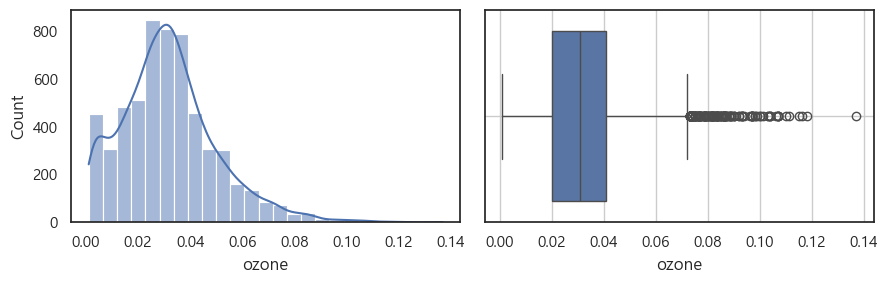

In [122]:
single_hist_box('ozone')

In [ ]:
# ozone
# 1~3사분위수 사이에 대부분의 값이 있음.
# 특별히 눈에 띄는 이상 없음.

In [14]:
def pearson_corr(x, y='count'):
    if y == 'count':
        print("<귀무가설> %s에 대한 자전거 대여량의 차이가 없다." % x)
    pr = spst.pearsonr(sbike_knn[x], sbike_knn[y])
    print("상관계수:", round(pr[0], 3))
    if pr[1] < 0.05:
        if pr[0] > 0:
            print("귀무가설 기각. %s-%s 양의 상관관계" % (x, y))
        elif pr[0] < 0:
            print("귀무가설 기각. %s-%s 음의 상관관계" % (x, y))
        else:
            print("귀무가설 기각. %s-%s 관계 없음" % (x, y))
    else:
        print("귀무가설을 기각하지 않는다. %s에 대한 %s의 차이가 없다." % (x, y))

In [31]:
pearson_corr('ozone')

<귀무가설> ozone에 대한 자전거 대여량의 차이가 없다.
상관계수: 0.315
귀무가설 기각. ozone-count 양의 상관관계


### 3-3> PM10, PM2.5
* 두 미세먼지 농도는 미세먼지의 크기차이이므로 함께 분석

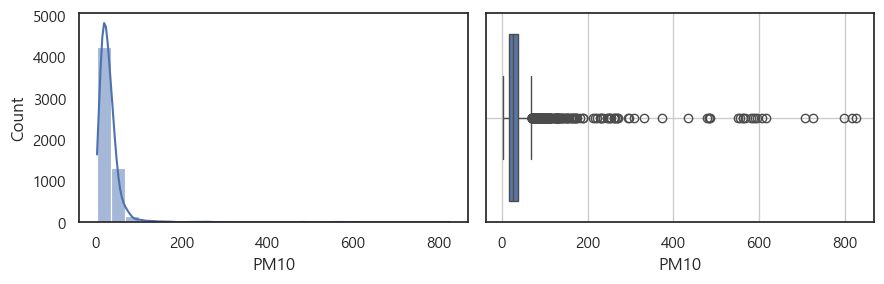

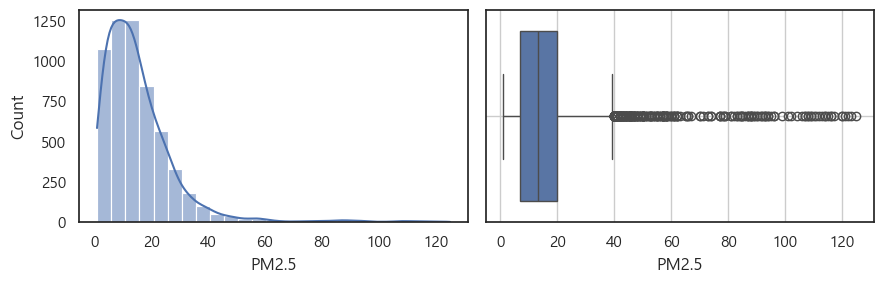

In [11]:
single_hist_box('PM10')
single_hist_box('PM2.5')

In [7]:
pearson_corr('PM10')
print()
pearson_corr('PM2.5')

<귀무가설> PM10에 대한 자전거 대여량의 차이가 없다.
상관계수: 0.028
귀무가설 기각. PM10-count 양의 상관관계

<귀무가설> PM2.5에 대한 자전거 대여량의 차이가 없다.
상관계수: 0.036
귀무가설 기각. PM2.5-count 양의 상관관계


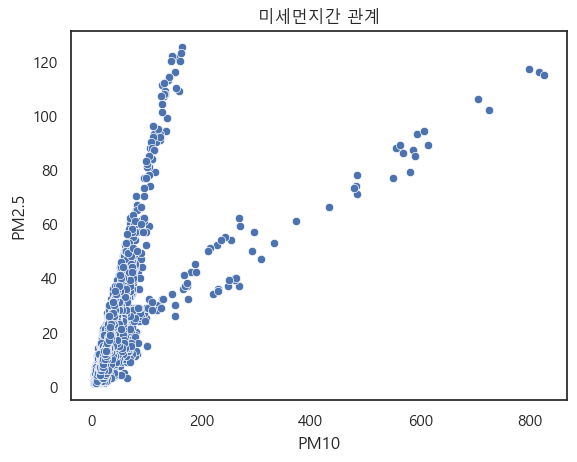

In [10]:
sns.scatterplot(data=sbike_knn, x='PM10', y='PM2.5')
plt.title("미세먼지간 관계")
plt.show()

In [15]:
pearson_corr(x='PM10', y='PM2.5')

상관계수: 0.684
귀무가설 기각. PM10-PM2.5 양의 상관관계


### 3-4> precipitation (범주형 변수)

In [41]:
sbike_knn['precipitation'].value_counts(normalize=True).round(3).to_frame() # 비가 오지 않은 시간대가 훨씬 많음.

,precipitation
0,0.924
1,0.076


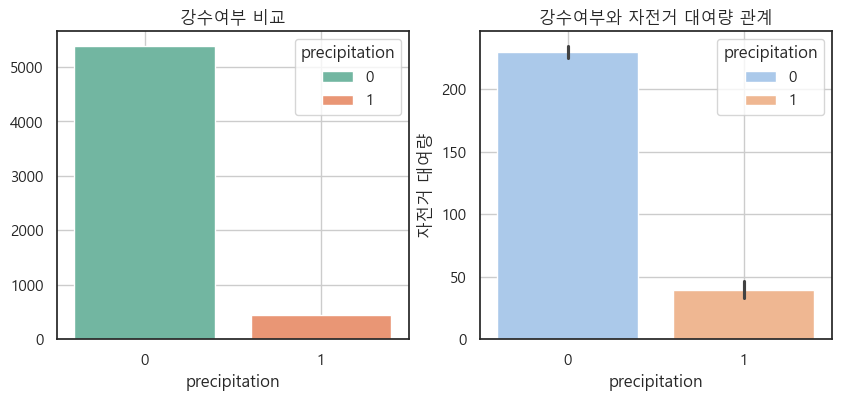

In [10]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.countplot(x=sbike_knn['precipitation'],
              hue=sbike_knn['precipitation'], palette='Set2')
plt.title("강수여부 비교")
plt.ylabel("")
plt.grid()

plt.subplot(1,2,2)
sns.barplot(x='precipitation', y='count', data=sbike_knn,
            hue=sbike_knn['precipitation'], palette='pastel')
plt.title("강수여부와 자전거 대여량 관계")
plt.ylabel("자전거 대여량")
plt.grid()

plt.show()

In [50]:
precipi_rainX = sbike_knn.loc[sbike_knn['precipitation'] == 0, 'count']
precipi_rainO = sbike_knn.loc[sbike_knn['precipitation'] == 1, 'count']

In [51]:
spst.ttest_ind(precipi_rainX, precipi_rainO) # 비가 오지 않을 때 자전거 대여량 평균이 높다.

Ttest_indResult(statistic=21.389614151911022, pvalue=8.86239184041254e-98)

### 3-5> windspeed

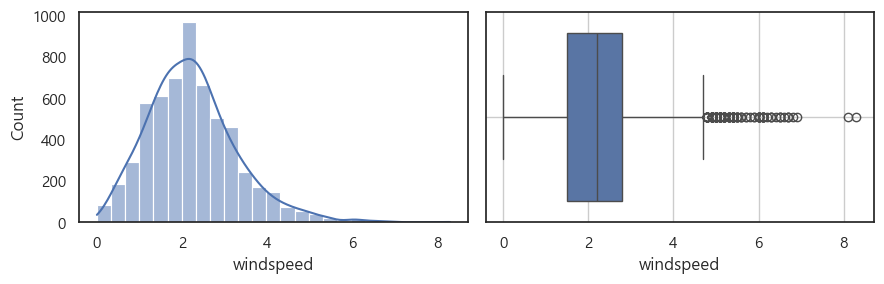

In [13]:
single_hist_box('windspeed')

In [16]:
pearson_corr('windspeed')

<귀무가설> windspeed에 대한 자전거 대여량의 차이가 없다.
상관계수: 0.224
귀무가설 기각. windspeed-count 양의 상관관계


### 3-6> humidity

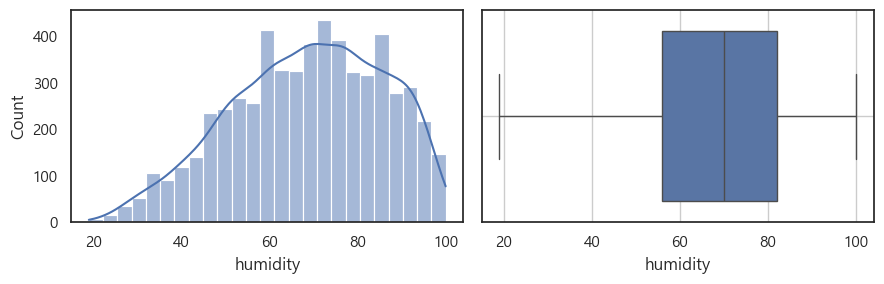

In [17]:
single_hist_box('humidity')

In [18]:
pearson_corr('humidity')

<귀무가설> humidity에 대한 자전거 대여량의 차이가 없다.
상관계수: -0.479
귀무가설 기각. humidity-count 음의 상관관계


### 3-7> visibility

In [25]:
sbike_knn['visibility'].value_counts(normalize=True).to_frame().sort_index(ascending=False)

,visibility
2000,0.723872
1999,0.000858
1998,0.000343
1997,0.001030
1996,0.001373
...,...
77,0.000172
73,0.000172
68,0.000172
61,0.000172


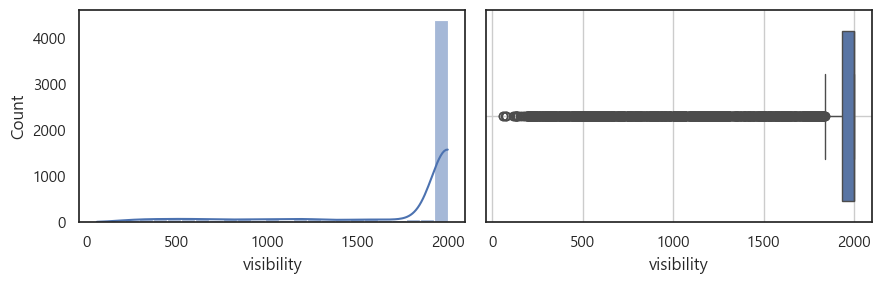

In [20]:
single_hist_box('visibility')

In [26]:
pearson_corr('visibility')

<귀무가설> visibility에 대한 자전거 대여량의 차이가 없다.
상관계수: 0.266
귀무가설 기각. visibility-count 양의 상관관계


## 4> 추가 분석

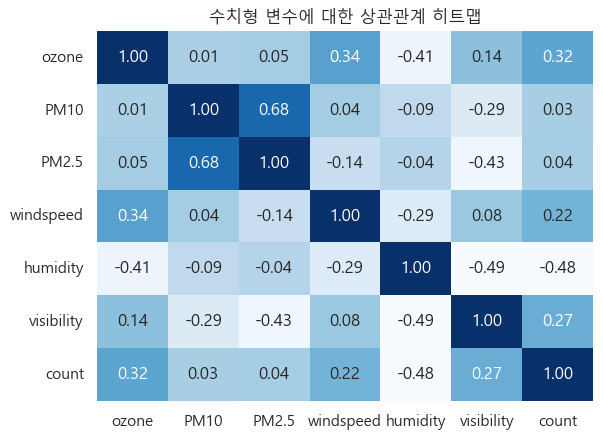

In [63]:
sbike_knn_hm = sbike_knn[['ozone', 'PM10', 'PM2.5', 'windspeed', 'humidity', 'visibility', 'count']].copy()
sns.heatmap(data=sbike_knn_hm.corr(),
            annot=True,
            fmt='.2f',
            cmap='Blues',
            cbar=False)
plt.title("수치형 변수에 대한 상관관계 히트맵")
plt.show()

### 4-1> 시간에 따른 대여량 비교
* 6~10시 (출근)
* 10~14시 (점심)
* 16~20시 (퇴근)
* 20~0시 (저녁산책)

In [45]:
hour6 = sbike_knn.loc[(sbike_knn['hour'] >= 6) & (sbike_knn['hour'] <= 10), 'count']
hour10 = sbike_knn.loc[(sbike_knn['hour'] >= 10) & (sbike_knn['hour'] <= 14), 'count']
hour16 = sbike_knn.loc[(sbike_knn['hour'] >= 16) & (sbike_knn['hour'] <= 20), 'count']
hour20 = sbike_knn.loc[(sbike_knn['hour'] >= 20) | (sbike_knn['hour'] == 1), 'count']

In [39]:
spst.ttest_ind(hour6, hour10) # 출근시간대보다 점심시간대의 대여량 평균이 높다.

Ttest_indResult(statistic=-14.9048310335258, pvalue=3.865782363063275e-48)

In [41]:
spst.ttest_ind(hour10, hour16) # 점심시간대보다 퇴근시간대의 대여량 평균이 높다.

Ttest_indResult(statistic=-29.962606539401474, pvalue=4.0723583112803193e-168)

In [46]:
spst.ttest_ind(hour16, hour20) # 저녁산책시간대보다 퇴근시간대의 대여량 평균이 높다.

Ttest_indResult(statistic=26.614124187145624, pvalue=3.721716162657217e-137)

In [48]:
print(spst.ttest_ind(hour10, hour20)) # 점심시간대와 저녁산책시간대의 대여량 평균은 그다지 차이가 없고,
print(spst.ttest_ind(hour6, hour20)) # 출근시간대보다 저녁산책시간대의 대여량 평균이 높다.

Ttest_indResult(statistic=0.00933390418883189, pvalue=0.9925534969086127)
Ttest_indResult(statistic=-11.380890194268334, pvalue=2.8355422837855293e-29)


* 자전거 대여량 시간대 순위
    - 6~10 < 10~14, 20~0 < 16~20

### 4-2> 계절에 따른 대여량 비교

In [59]:
spring = sbike_knn.loc[(sbike_knn['date'].dt.month >= 3) & (sbike_knn['date'].dt.month <= 5), 'count']
summer = sbike_knn.loc[(sbike_knn['date'].dt.month >= 6) & (sbike_knn['date'].dt.month <= 8), 'count']
autumn = sbike_knn.loc[(sbike_knn['date'].dt.month >= 9) & (sbike_knn['date'].dt.month <= 11), 'count']

In [60]:
spst.ttest_ind(spring, summer) # 봄과 여름의 대여량 평균은 그다지 차이가 없다.

Ttest_indResult(statistic=0.6420519786778461, pvalue=0.5208795788845337)

In [61]:
spst.ttest_ind(spring, autumn) # 봄보다 가을의 대여량 평균이 높다.

Ttest_indResult(statistic=-2.4424180574850016, pvalue=0.014636794553064263)

In [62]:
spst.ttest_ind(summer, autumn) # 여름보다 가을의 대여량 평균이 높다.

Ttest_indResult(statistic=-3.621267148223376, pvalue=0.00029649347728705975)

* 자전거 대여량 계절 순위
    - 봄, 여름 < 가을

## 5> 인사이트 및 결론

* precipitation, 비가 오면 자전거 대여량이 매우 감소한다.

* ozone 농도, windspeed, visibility가 높을수록, humidity가 낮을수록
<br>자전거 대여량이 많아지는 약한 상관관계가 있다.

* 봄이나 여름보다는 가을에 자전거 대여량이 많아진다.

* 퇴근시간대가 자전거 대여량이 가장 많고, 출근시간대에 가장 적다.